# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import get_distribution_info, load_beam, plot_distribution
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [4]:
-np.log(8)

-2.0794415416798357

In [5]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            "reference_parameters_h_v": {"peak_distance": (0.0, 0.0)},
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["negative_log_peak_intensity", "peak_distance"],#["peak", "fwhm", "weighted_sum_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"peak_distance":0.02, "negative_log_peak_intensity":-np.log(8)},
        }

In [6]:
class SimulationParameters:
    def __init__(self):
        detector_x = 2160 * 0.65 * 1e-3
        detector_y = 2560 * 0.65 * 1e-3

        xrange = [-detector_x / 2, detector_x / 2]
        yrange = [-detector_y / 2, detector_y / 2]

        self.params = {
            "xrange": xrange,
            "yrange": yrange,
            "nbins_h": 2048,
            "nbins_v": 2048,
            "do_gaussian_fit": False,
            "implementor": Implementors.SHADOW,
            "random_seed": DEFAULT_RANDOM_SEED,
        }

In [7]:

def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [56]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype, lfn in loss_dw_functions.items():
        if ltype in loss_parameters:
            loss = lfn(dw)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    for ltype, lfn in loss_hist_functions.items():
        if ltype in loss_parameters:
            loss = lfn(hist)
            attribs[ltype] = loss
            print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [9]:
plot_mode = PlotMode.INTERNAL
aspect_ratio = AspectRatio.AUTO
color_map = ColorMap.VIRIDIS

In [10]:
setup_work_dir()
clean_up()

sim_params = SimulationParameters()
print("Simulation parameters")
print(sim_params.__dict__)

Simulation parameters
{'params': {'xrange': [-0.7020000000000001, 0.7020000000000001], 'yrange': [-0.8320000000000001, 0.8320000000000001], 'nbins_h': 2048, 'nbins_v': 2048, 'do_gaussian_fit': False, 'implementor': 0, 'random_seed': 91282}}


In [11]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'reference_parameters_h_v': {'peak_distance': (0.0, 0.0)}, 'loss_parameters': ['negative_log_peak_intensity', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'peak_distance': 0.02, 'negative_log_peak_intensity': -2.0794415416798357}}


In [12]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


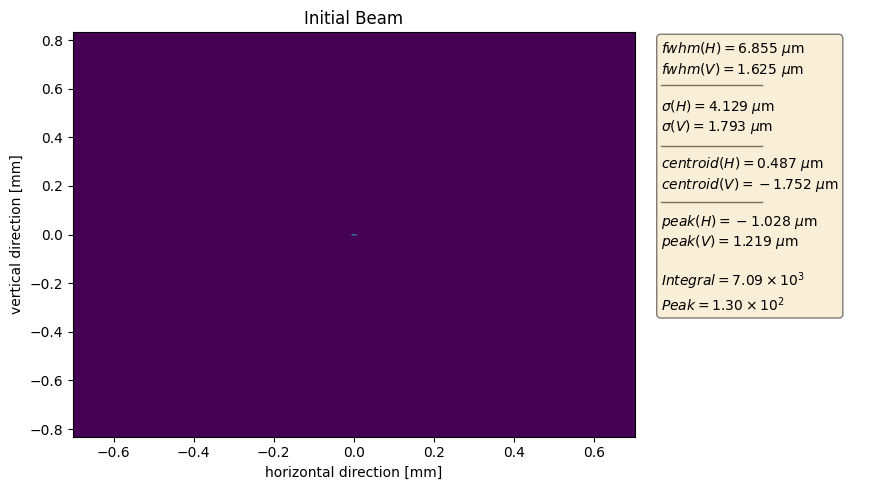

In [13]:
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

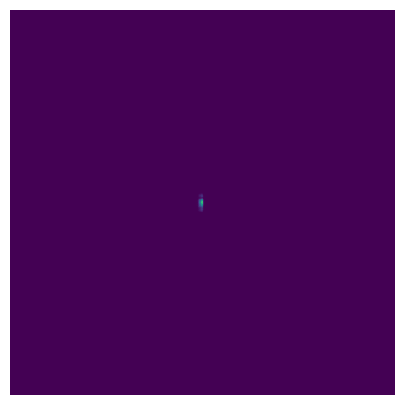

In [14]:
plt.figure(figsize=[5, 5])
plt.imshow(hist.data_2D[700:-700,700:-700])
plt.axis("off")
plt.show()

In [15]:
attribs_focus = print_beam_attributes(["peak", "fwhm", "weighted_sum_intensity"], hist, dw, "Focused beam")

Focused beam system peak: 1.106e-03
Focused beam system fwhm: 7.045e-03
Focused beam system weighted_sum_intensity: 1.670e-01


In [16]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [17]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    **sim_params.params,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-192.9, -155.9, 0.17218733853924986, 0.0516, 408.7, 0.17076733853924986, 0.0062]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-24.860340701948747, 5.121103312478244, 0.00027570129597402973, 0.025791945123060468, -10.33233937587459, -0.0011217500000786002, 0.006187594949814565]


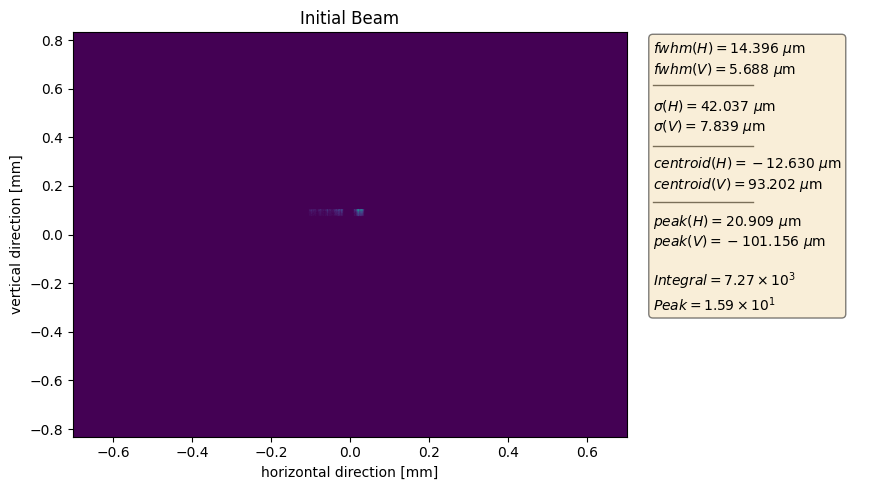

In [18]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [20]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS, moving all motors together

In [98]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


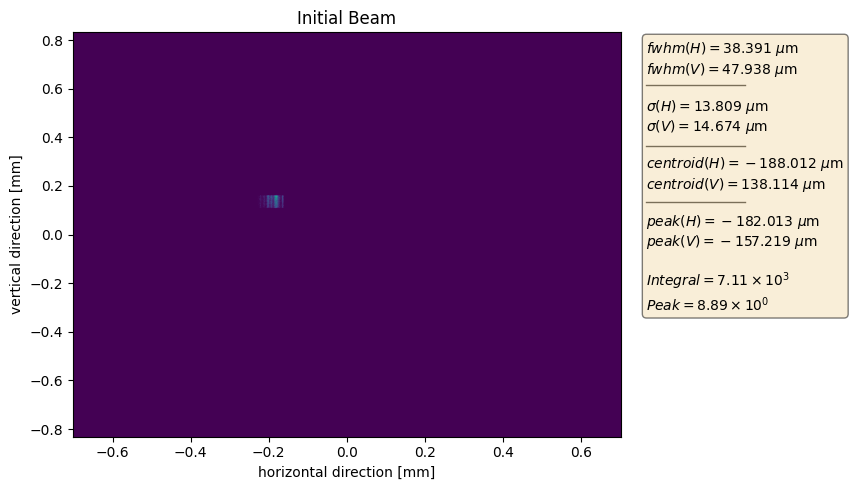

In [99]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [57]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system log_weighted_sum_intensity: 4.250e+00


In [58]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [59]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=opt_params.params["moo_thresholds"]
)

[I 2022-11-18 14:33:33,535] A new study created in memory with name: no-name-b20c074f-2ab8-4c37-9691-52fcbc7c6814


In [ ]:
opt_trial.trials(150)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


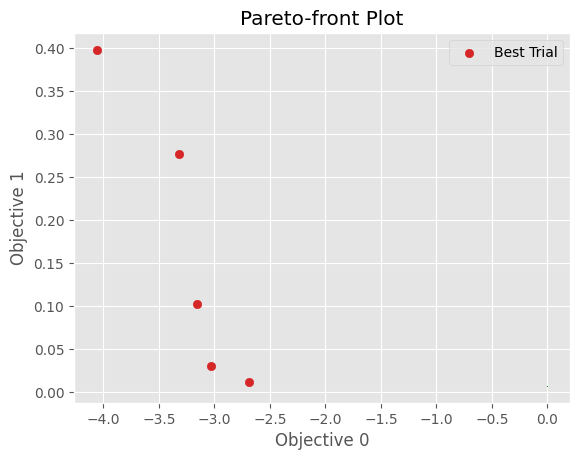

In [104]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

In [105]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 167.32037005406352
nan 848.8003514509451
nan 17.846029104620303
nan 20.74446046401871
nan 6.854360269430533


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_45721/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-4.062101212155052, 0.39792584125281044]
[-4.062101212155052, 0.39792584125281044]


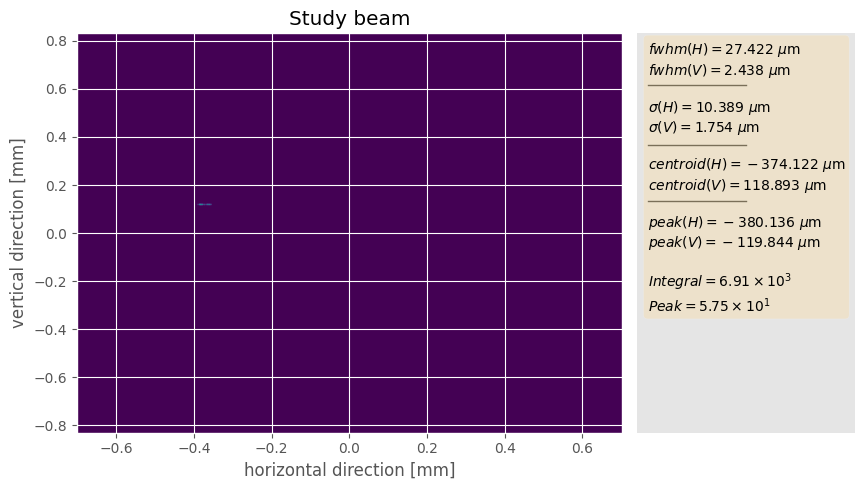

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.3189971356169745, 0.27703912373480766]
[-3.3189971356169745, 0.27703912373480766]


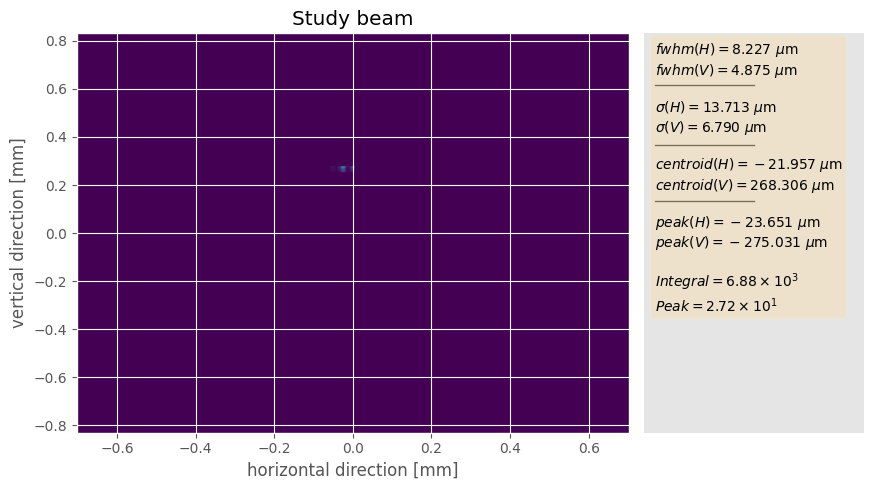

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.155959819290567, 0.10207199966782292]
[-3.155959819290567, 0.10207199966782292]


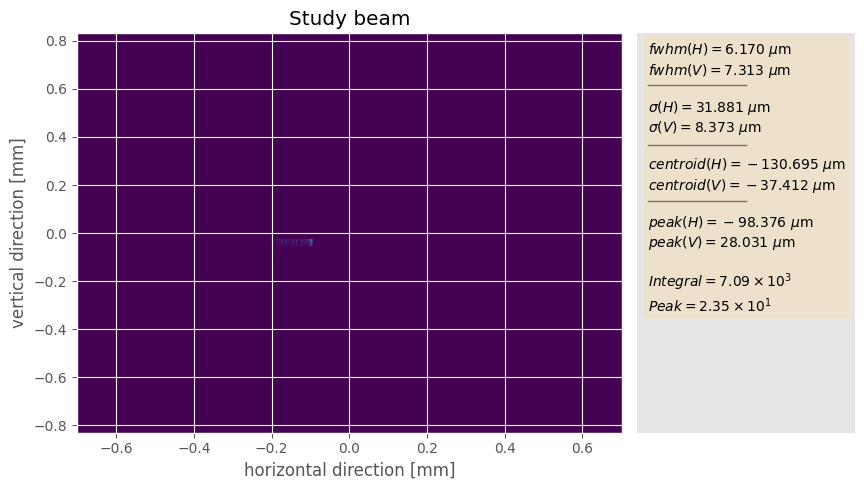

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-3.030912582113237, 0.03050858987948527]
[-3.030912582113237, 0.03050858987948527]


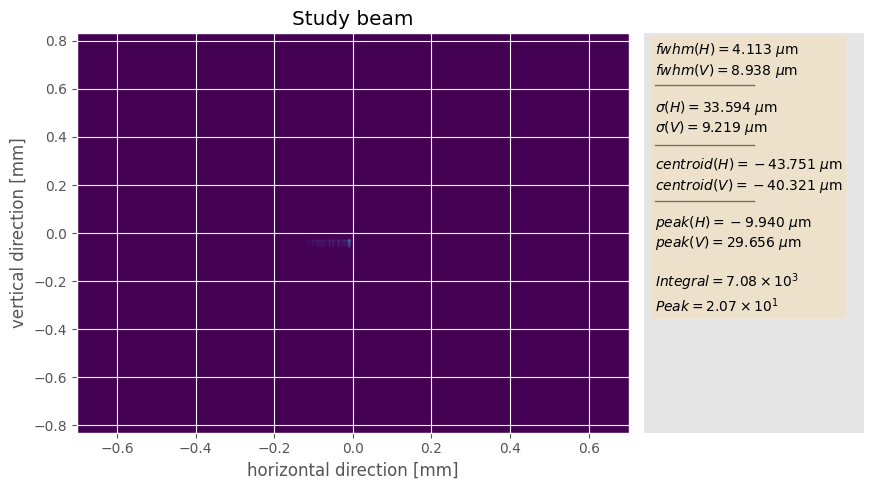

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-2.6862199154427358, 0.01103327836794192]
[-2.6862199154427358, 0.01103327836794192]


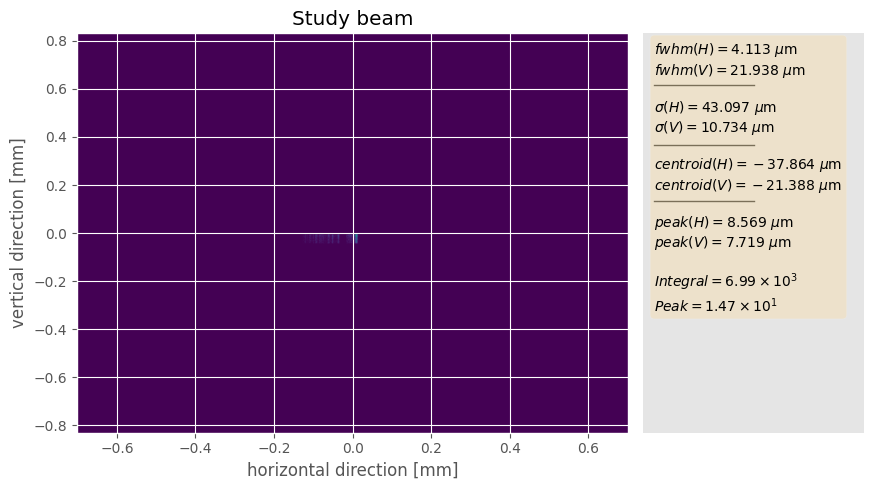

In [108]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()
    plot_distribution(
        beam=opt_trial.beam_state.photon_beam,
        title="Study beam",
        plot_mode=plot_mode,
        aspect_ratio=aspect_ratio,
        color_map=color_map,
        **sim_params.params,
    )

#### WITH MOO THRESHOLDS, moving all motors together

In [61]:
opt_params = OptimizationParameters()

In [62]:
opt_params.params

{'sum_intensity_soft_constraint': 7000.0,
 'sum_intensity_hard_constraint': 6500.0,
 'reference_parameters_h_v': {'peak_distance': (0.0, 0.0)},
 'loss_parameters': ['negative_log_peak_intensity', 'peak_distance'],
 'multi_objective_optimization': True,
 'n_pitch_trans_motor_trials': 50,
 'n_all_motor_trials': 100,
 'moo_thresholds': {'peak_distance': 0.02,
  'negative_log_peak_intensity': -2.0794415416798357}}

In [63]:
opt_params.params['loss_parameters'] = ["log_weighted_sum_intensity"]
opt_params.params["multi_objective_optimization"] = False
opt_params.params["moo_thresholds"] = None
opt_params.params["reference_parameters_h_v"] = {}

In [64]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


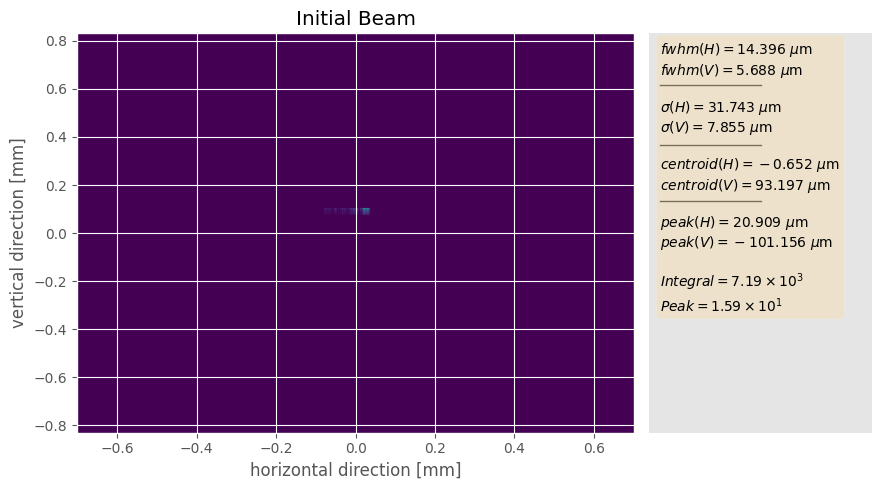

In [65]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(focusing_system=focusing_system, photon_beam=None, **sim_params.params)
plot_distribution(
    beam=beam_pert,
    title="Initial Beam",
    plot_mode=plot_mode,
    aspect_ratio=aspect_ratio,
    color_map=color_map,
    **sim_params.params,
)

In [66]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system log_weighted_sum_intensity: 4.250e+00


In [67]:
# Now the optimization
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    reference_parameters_h_v=opt_params.params["reference_parameters_h_v"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    **sim_params.params,
    )

In [68]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=opt_params.params["moo_thresholds"]
)

[I 2022-11-18 14:34:06,081] A new study created in memory with name: no-name-f4044ac1-cf10-418f-9ed6-c253c0410eda


In [69]:
opt_trial.trials(50, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:336: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
[I 2022-11-18 14:34:06,937] Trial 0 finished with value: 4.250408490988105 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. Best is trial 0 with value: 4.250408490988105.
[I 2022-11-18 14:34:07,185] Trial 1 finished with value: 5.125232757661698 and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.011700000000000002, 'vb_bender': 0.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.0045999999999999965}. Best is trial 0 with value: 4.250408490988105.
[I 2022-11-18 14:34:07,436] Trial 2 finished with value: 5.888804852606252 and parameters: {

In [70]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:15,719] Trial 50 finished with value: 5.721337108932886 and parameters: {'hb_1': -20.0, 'hb_2': -9.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.006500000000000006, 'vb_bender': 17.0, 'vb_pitch': -0.001, 'vb_trans': 0.016900000000000005}. Best is trial 16 with value: 2.9793200353510585.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:17,298] Trial 51 finished with value: 5.894905881379667 and parameters: {'hb_1': -16.0, 'hb_2': -4.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.0017000000000000001, 'vb_bender': -8.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.0059000000000000025}. Best is trial 16 with value: 2.9793200353510585.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:19,082] Trial 52 finished with value: 6.078928655464423 and parameters: {'hb_1': -5.0, 'hb_2': 1.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.0264, 'vb_bender': -4.0, 'vb_pitch': -0.002, 'vb_trans': -0.018799999999999997}. Best is trial 16 with value: 2.9793200353510585.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:20,725] Trial 53 finished with value: 2.958965277783431 and parameters: {'hb_1': 17.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0206, 'vb_bender': -7.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': 0.022200000000000004}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:22,440] Trial 54 finished with value: 5.5675560318027495 and parameters: {'hb_1': 6.0, 'hb_2': -25.0, 'hb_pitch': 0.0, 'hb_trans': 0.010100000000000005, 'vb_bender': 6.0, 'vb_pitch': -0.00116, 'vb_trans': -0.004499999999999997}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:24,425] Trial 55 finished with value: 5.729787282211062 and parameters: {'hb_1': -9.0, 'hb_2': -5.0, 'hb_pitch': 0.0018, 'hb_trans': -0.017299999999999996, 'vb_bender': -13.0, 'vb_pitch': 0.0009000000000000002, 'vb_trans': 0.008100000000000003}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:25,935] Trial 56 finished with value: 5.858855423765294 and parameters: {'hb_1': 9.0, 'hb_2': -19.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.017600000000000005, 'vb_bender': -19.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': -0.0127}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:27,824] Trial 57 finished with value: 5.062156423375245 and parameters: {'hb_1': -24.0, 'hb_2': 19.0, 'hb_pitch': -0.0009, 'hb_trans': -0.003999999999999997, 'vb_bender': 9.0, 'vb_pitch': 0.0017000000000000001, 'vb_trans': -0.023799999999999998}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:29,840] Trial 58 finished with value: 3.9185766498222585 and parameters: {'hb_1': -7.0, 'hb_2': -16.0, 'hb_pitch': 0.0005, 'hb_trans': 0.013400000000000002, 'vb_bender': 3.0, 'vb_pitch': 0.00082, 'vb_trans': 0.004900000000000002}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:31,350] Trial 59 finished with value: 6.643587288036469 and parameters: {'hb_1': 6.0, 'hb_2': 2.0, 'hb_pitch': 0.0018, 'hb_trans': -0.026799999999999997, 'vb_bender': 18.0, 'vb_pitch': -0.00182, 'vb_trans': 0.018500000000000003}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:32,806] Trial 60 finished with value: 5.139358688536746 and parameters: {'hb_1': -15.0, 'hb_2': 1.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.012399999999999998, 'vb_bender': 14.0, 'vb_pitch': -0.00104, 'vb_trans': -0.026699999999999998}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:34,362] Trial 61 finished with value: 5.91211179836033 and parameters: {'hb_1': -11.0, 'hb_2': -12.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.022899999999999997, 'vb_bender': 3.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': -0.004899999999999998}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:35,821] Trial 62 finished with value: 5.016380022870784 and parameters: {'hb_1': 20.0, 'hb_2': -6.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': -0.006699999999999998}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:37,599] Trial 63 finished with value: 4.403673048632727 and parameters: {'hb_1': -13.0, 'hb_2': 12.0, 'hb_pitch': 0.001, 'hb_trans': 0.0284, 'vb_bender': 9.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': -0.0045999999999999965}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:39,360] Trial 64 finished with value: 5.462294350381344 and parameters: {'hb_1': -8.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.005499999999999998, 'vb_bender': 19.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0189}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:40,963] Trial 65 finished with value: 5.655281908772798 and parameters: {'hb_1': -4.0, 'hb_2': 19.0, 'hb_pitch': -0.0018, 'hb_trans': -0.019299999999999998, 'vb_bender': 6.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.0257}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:43,088] Trial 66 finished with value: 3.04938554246333 and parameters: {'hb_1': 10.0, 'hb_2': 20.0, 'hb_pitch': 0.0005, 'hb_trans': -0.005799999999999996, 'vb_bender': 2.0, 'vb_pitch': 0.0012400000000000002, 'vb_trans': 0.006900000000000003}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:45,090] Trial 67 finished with value: 4.499838042102006 and parameters: {'hb_1': -18.0, 'hb_2': 1.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.029400000000000003, 'vb_bender': 2.0, 'vb_pitch': 0.0004000000000000002, 'vb_trans': 0.027600000000000006}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:46,937] Trial 68 finished with value: 5.602978256158577 and parameters: {'hb_1': -20.0, 'hb_2': 9.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.011699999999999999, 'vb_bender': 14.0, 'vb_pitch': -0.00122, 'vb_trans': 0.00010000000000000286}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:48,869] Trial 69 finished with value: 6.427484199155029 and parameters: {'hb_1': 0.0, 'hb_2': -2.0, 'hb_pitch': -0.0019, 'hb_trans': 0.019100000000000006, 'vb_bender': -12.0, 'vb_pitch': -0.001, 'vb_trans': 0.0155}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:50,507] Trial 70 finished with value: 5.46416457350586 and parameters: {'hb_1': -2.0, 'hb_2': 9.0, 'hb_pitch': 0.001, 'hb_trans': 0.005700000000000004, 'vb_bender': 8.0, 'vb_pitch': -0.00074, 'vb_trans': -0.0013999999999999985}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:52,154] Trial 71 finished with value: 5.851745278321389 and parameters: {'hb_1': -23.0, 'hb_2': -16.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.028600000000000007, 'vb_bender': 1.0, 'vb_pitch': -0.00056, 'vb_trans': 0.005300000000000006}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:53,931] Trial 72 finished with value: 5.5868710025800805 and parameters: {'hb_1': -19.0, 'hb_2': 20.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.012199999999999999, 'vb_bender': 2.0, 'vb_pitch': -0.001, 'vb_trans': 0.0238}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:55,506] Trial 73 finished with value: 5.7896474623104535 and parameters: {'hb_1': -7.0, 'hb_2': 4.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.002599999999999998, 'vb_bender': -9.0, 'vb_pitch': -0.00164, 'vb_trans': -0.0174}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:57,455] Trial 74 finished with value: 5.812501206845612 and parameters: {'hb_1': 20.0, 'hb_2': -25.0, 'hb_pitch': 0.0013, 'hb_trans': 0.022400000000000003, 'vb_bender': 3.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': 0.027500000000000004}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:35:59,545] Trial 75 finished with value: 5.330799072090166 and parameters: {'hb_1': -25.0, 'hb_2': -10.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.024900000000000005, 'vb_bender': 4.0, 'vb_pitch': 6.000000000000016e-05, 'vb_trans': 0.0039000000000000007}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:01,462] Trial 76 finished with value: 5.959429598344695 and parameters: {'hb_1': -17.0, 'hb_2': 16.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0168, 'vb_bender': 8.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.024400000000000005}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:03,395] Trial 77 finished with value: 6.147508309919232 and parameters: {'hb_1': -12.0, 'hb_2': -16.0, 'hb_pitch': -0.0009, 'hb_trans': 0.019100000000000006, 'vb_bender': 16.0, 'vb_pitch': -0.0016, 'vb_trans': -0.007599999999999999}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:05,163] Trial 78 finished with value: 5.576795276682911 and parameters: {'hb_1': -7.0, 'hb_2': 11.0, 'hb_pitch': -0.0013, 'hb_trans': 0.012100000000000007, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0033000000000000043}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:06,790] Trial 79 finished with value: 5.9963756698896855 and parameters: {'hb_1': 11.0, 'hb_2': -2.0, 'hb_pitch': -0.0016, 'hb_trans': 0.0299, 'vb_bender': -13.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': -0.017099999999999997}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:08,540] Trial 80 finished with value: 4.294434531585857 and parameters: {'hb_1': 10.0, 'hb_2': -22.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0293, 'vb_bender': 15.0, 'vb_pitch': 0.00186, 'vb_trans': -0.0174}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:10,385] Trial 81 finished with value: 6.3897716392332224 and parameters: {'hb_1': 22.0, 'hb_2': 14.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.022799999999999997, 'vb_bender': 16.0, 'vb_pitch': -0.0014399999999999999, 'vb_trans': 0.0097}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:12,344] Trial 82 finished with value: 5.7094089078129135 and parameters: {'hb_1': 15.0, 'hb_2': 6.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.0266, 'vb_bender': 11.0, 'vb_pitch': 0.0011200000000000003, 'vb_trans': 0.022500000000000006}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:14,099] Trial 83 finished with value: 4.113189516267616 and parameters: {'hb_1': -24.0, 'hb_2': -6.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.001799999999999996, 'vb_bender': 16.0, 'vb_pitch': 0.0014000000000000002, 'vb_trans': 0.014700000000000005}. Best is trial 53 with value: 2.958965277783431.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:15,824] Trial 84 finished with value: 2.334007216200386 and parameters: {'hb_1': 3.0, 'hb_2': 7.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.0023000000000000034, 'vb_bender': 8.0, 'vb_pitch': 0.00102, 'vb_trans': -0.0138}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:17,509] Trial 85 finished with value: 5.215700979224635 and parameters: {'hb_1': 15.0, 'hb_2': 22.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.0187, 'vb_bender': -3.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': -0.002999999999999999}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:19,549] Trial 86 finished with value: 5.457377244633316 and parameters: {'hb_1': 15.0, 'hb_2': 17.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0006000000000000033, 'vb_bender': -16.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.0249}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:21,460] Trial 87 finished with value: 3.550889763583574 and parameters: {'hb_1': 23.0, 'hb_2': -5.0, 'hb_pitch': -0.001, 'hb_trans': -0.0218, 'vb_bender': -17.0, 'vb_pitch': 0.00136, 'vb_trans': 0.028600000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:23,516] Trial 88 finished with value: 5.108467296484082 and parameters: {'hb_1': -2.0, 'hb_2': 9.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.011500000000000003, 'vb_bender': -10.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.0031000000000000055}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:25,516] Trial 89 finished with value: 5.393868842619128 and parameters: {'hb_1': -25.0, 'hb_2': 9.0, 'hb_pitch': -0.0013, 'hb_trans': -0.0133, 'vb_bender': 5.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': -0.0253}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:28,838] Trial 90 finished with value: 4.952910234058826 and parameters: {'hb_1': 5.0, 'hb_2': -12.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.018400000000000007, 'vb_bender': 1.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': -0.019799999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:30,905] Trial 91 finished with value: 5.306954741413259 and parameters: {'hb_1': 22.0, 'hb_2': 19.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.0075, 'vb_bender': -11.0, 'vb_pitch': 0.0010600000000000002, 'vb_trans': 0.009000000000000001}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:32,619] Trial 92 finished with value: 5.225392771787955 and parameters: {'hb_1': 13.0, 'hb_2': -18.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.015100000000000002, 'vb_bender': -3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0019999999999999983}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:34,438] Trial 93 finished with value: 3.7109750608693033 and parameters: {'hb_1': 15.0, 'hb_2': 18.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.017599999999999998, 'vb_bender': 16.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.010799999999999997}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:36,772] Trial 94 finished with value: 2.867463365331577 and parameters: {'hb_1': 16.0, 'hb_2': 9.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': -0.0011999999999999962, 'vb_bender': 3.0, 'vb_pitch': 0.0014000000000000002, 'vb_trans': 0.018400000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:38,669] Trial 95 finished with value: 5.922117778990646 and parameters: {'hb_1': 1.0, 'hb_2': 7.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.006299999999999997, 'vb_bender': -1.0, 'vb_pitch': -0.00118, 'vb_trans': 0.0092}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:40,547] Trial 96 finished with value: 6.347616751445764 and parameters: {'hb_1': -8.0, 'hb_2': -6.0, 'hb_pitch': 0.0019, 'hb_trans': -0.005499999999999998, 'vb_bender': -19.0, 'vb_pitch': -0.00108, 'vb_trans': 0.0216}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:42,269] Trial 97 finished with value: 5.846829051862743 and parameters: {'hb_1': 19.0, 'hb_2': 9.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.029699999999999997, 'vb_bender': 7.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': 0.018400000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:44,103] Trial 98 finished with value: 4.902043654771447 and parameters: {'hb_1': 7.0, 'hb_2': -23.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.020699999999999996, 'vb_bender': -11.0, 'vb_pitch': -0.0003799999999999999, 'vb_trans': -0.0224}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:46,591] Trial 99 finished with value: 5.537679903052847 and parameters: {'hb_1': 23.0, 'hb_2': -15.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.015600000000000003, 'vb_bender': -19.0, 'vb_pitch': 0.00134, 'vb_trans': 0.018300000000000004}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:48,804] Trial 100 finished with value: 3.0119628507282767 and parameters: {'hb_1': 6.0, 'hb_2': 15.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.0119, 'vb_bender': -3.0, 'vb_pitch': 0.00118, 'vb_trans': -0.013399999999999999}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:50,917] Trial 101 finished with value: 5.0133865235102375 and parameters: {'hb_1': 20.0, 'hb_2': 25.0, 'hb_pitch': -0.0013, 'hb_trans': -0.003499999999999996, 'vb_bender': -12.0, 'vb_pitch': 0.0012800000000000003, 'vb_trans': 0.009800000000000003}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:53,124] Trial 102 finished with value: 4.986642245465886 and parameters: {'hb_1': -6.0, 'hb_2': 6.0, 'hb_pitch': -0.0013, 'hb_trans': -0.010199999999999997, 'vb_bender': 15.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': -0.0277}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:55,479] Trial 103 finished with value: 3.090832585732849 and parameters: {'hb_1': 3.0, 'hb_2': 19.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0031000000000000055, 'vb_bender': 0.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': -0.014099999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:57,440] Trial 104 finished with value: 6.4152662669219565 and parameters: {'hb_1': -24.0, 'hb_2': 23.0, 'hb_pitch': 0.0018, 'hb_trans': -0.016099999999999996, 'vb_bender': 18.0, 'vb_pitch': -0.00172, 'vb_trans': 0.0063}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:36:59,634] Trial 105 finished with value: 5.838212908907654 and parameters: {'hb_1': 6.0, 'hb_2': -20.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.010300000000000004, 'vb_bender': 19.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': -0.011099999999999999}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:01,815] Trial 106 finished with value: 6.14802316412362 and parameters: {'hb_1': 22.0, 'hb_2': 15.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.002600000000000005, 'vb_bender': 5.0, 'vb_pitch': -0.0013800000000000002, 'vb_trans': 0.023400000000000004}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:03,533] Trial 107 finished with value: 6.002726766212809 and parameters: {'hb_1': -17.0, 'hb_2': 2.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.029500000000000005, 'vb_bender': -9.0, 'vb_pitch': -0.00186, 'vb_trans': -0.0294}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:05,708] Trial 108 finished with value: 5.651281535217923 and parameters: {'hb_1': 15.0, 'hb_2': 14.0, 'hb_pitch': -0.0013, 'hb_trans': 0.025800000000000003, 'vb_bender': 7.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.008900000000000005}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:07,481] Trial 109 finished with value: 3.630299836138078 and parameters: {'hb_1': 3.0, 'hb_2': -1.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -9.999999999999593e-05, 'vb_bender': 7.0, 'vb_pitch': 0.00082, 'vb_trans': -0.0242}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:09,258] Trial 110 finished with value: 6.262174593076942 and parameters: {'hb_1': -10.0, 'hb_2': -1.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.009900000000000006, 'vb_bender': 19.0, 'vb_pitch': -0.00188, 'vb_trans': 0.0262}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:11,320] Trial 111 finished with value: 3.59176792315801 and parameters: {'hb_1': 10.0, 'hb_2': -14.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0238, 'vb_bender': 17.0, 'vb_pitch': 0.00066, 'vb_trans': 0.0021000000000000046}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:13,079] Trial 112 finished with value: 5.370038973643462 and parameters: {'hb_1': 2.0, 'hb_2': -1.0, 'hb_pitch': 0.0005, 'hb_trans': 0.027800000000000005, 'vb_bender': -11.0, 'vb_pitch': -0.0006799999999999998, 'vb_trans': 0.016300000000000002}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:15,154] Trial 113 finished with value: 5.642396867887006 and parameters: {'hb_1': -2.0, 'hb_2': -23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.0023999999999999994, 'vb_bender': 20.0, 'vb_pitch': 0.0005, 'vb_trans': -0.0116}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:17,374] Trial 114 finished with value: 5.481674449592 and parameters: {'hb_1': 16.0, 'hb_2': 18.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.027000000000000003, 'vb_bender': 13.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': 0.003600000000000006}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:19,239] Trial 115 finished with value: 5.295990815615113 and parameters: {'hb_1': 24.0, 'hb_2': -9.0, 'hb_pitch': 0.0005, 'hb_trans': -0.007099999999999999, 'vb_bender': -3.0, 'vb_pitch': -0.00098, 'vb_trans': -0.027299999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:21,489] Trial 116 finished with value: 5.115930884148661 and parameters: {'hb_1': 0.0, 'hb_2': -3.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.0010999999999999968, 'vb_bender': -10.0, 'vb_pitch': -0.0008799999999999999, 'vb_trans': -0.017799999999999996}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:23,902] Trial 117 finished with value: 6.33557187519996 and parameters: {'hb_1': -25.0, 'hb_2': 25.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.016400000000000005, 'vb_bender': -9.0, 'vb_pitch': -0.00158, 'vb_trans': -0.021199999999999997}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:26,787] Trial 118 finished with value: 6.265285266946336 and parameters: {'hb_1': 4.0, 'hb_2': -15.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.0093, 'vb_bender': 17.0, 'vb_pitch': -0.00188, 'vb_trans': 0.016700000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:28,726] Trial 119 finished with value: 6.22692158235798 and parameters: {'hb_1': -24.0, 'hb_2': -1.0, 'hb_pitch': -0.002, 'hb_trans': 0.023900000000000005, 'vb_bender': 14.0, 'vb_pitch': 0.0018200000000000004, 'vb_trans': 0.025300000000000003}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:30,384] Trial 120 finished with value: 2.484849138562487 and parameters: {'hb_1': 24.0, 'hb_2': -7.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.006400000000000003, 'vb_bender': -14.0, 'vb_pitch': 0.0005600000000000002, 'vb_trans': -0.024399999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:32,364] Trial 121 finished with value: 5.770670226219902 and parameters: {'hb_1': -21.0, 'hb_2': -3.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0131, 'vb_bender': -20.0, 'vb_pitch': -0.0007999999999999999, 'vb_trans': -0.012299999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:34,401] Trial 122 finished with value: 5.260314667933275 and parameters: {'hb_1': -12.0, 'hb_2': -6.0, 'hb_pitch': -0.001, 'hb_trans': 0.008800000000000002, 'vb_bender': -17.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.022600000000000002}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:36,554] Trial 123 finished with value: 4.987831672826464 and parameters: {'hb_1': -5.0, 'hb_2': 4.0, 'hb_pitch': 0.0005, 'hb_trans': -0.0063999999999999994, 'vb_bender': 3.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.012300000000000005}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:38,846] Trial 124 finished with value: 6.194873570486879 and parameters: {'hb_1': 15.0, 'hb_2': -14.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.029400000000000003, 'vb_bender': 13.0, 'vb_pitch': -0.0015400000000000001, 'vb_trans': -0.0104}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:40,911] Trial 125 finished with value: 4.703427589512812 and parameters: {'hb_1': 12.0, 'hb_2': -21.0, 'hb_pitch': 0.0005, 'hb_trans': 0.010500000000000002, 'vb_bender': -19.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': -0.011299999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:43,019] Trial 126 finished with value: 3.8754200838457704 and parameters: {'hb_1': -25.0, 'hb_2': -25.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.011799999999999998, 'vb_bender': -20.0, 'vb_pitch': 0.0013200000000000004, 'vb_trans': -0.0269}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:45,257] Trial 127 finished with value: 6.320105693304645 and parameters: {'hb_1': -19.0, 'hb_2': 7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.007800000000000001, 'vb_bender': -8.0, 'vb_pitch': -0.00188, 'vb_trans': 0.027700000000000002}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:47,831] Trial 128 finished with value: 6.025130682555581 and parameters: {'hb_1': 16.0, 'hb_2': -17.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.0097, 'vb_bender': 10.0, 'vb_pitch': -0.00176, 'vb_trans': -0.009599999999999997}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:50,456] Trial 129 finished with value: 6.458074059298961 and parameters: {'hb_1': -6.0, 'hb_2': -24.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.0068000000000000005, 'vb_bender': -6.0, 'vb_pitch': -0.00156, 'vb_trans': 0.023000000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:53,135] Trial 130 finished with value: 4.021203845743601 and parameters: {'hb_1': 17.0, 'hb_2': -7.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.013399999999999999, 'vb_bender': -14.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': 0.0257}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:55,409] Trial 131 finished with value: 4.728671738137702 and parameters: {'hb_1': -10.0, 'hb_2': 4.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.011799999999999998, 'vb_bender': -12.0, 'vb_pitch': 0.0005600000000000002, 'vb_trans': -0.020399999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:37:58,013] Trial 132 finished with value: 3.8450501010237836 and parameters: {'hb_1': -2.0, 'hb_2': 10.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.004099999999999996, 'vb_bender': -17.0, 'vb_pitch': 0.00196, 'vb_trans': 0.002800000000000004}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:00,471] Trial 133 finished with value: 5.903584572792536 and parameters: {'hb_1': -9.0, 'hb_2': 6.0, 'hb_pitch': -0.0018, 'hb_trans': -0.023799999999999998, 'vb_bender': -6.0, 'vb_pitch': -0.0007799999999999999, 'vb_trans': -0.0226}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:03,130] Trial 134 finished with value: 3.9684761457756133 and parameters: {'hb_1': -24.0, 'hb_2': -1.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.011600000000000006, 'vb_bender': 0.0, 'vb_pitch': 0.00082, 'vb_trans': -0.028399999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:05,263] Trial 135 finished with value: 5.721020580286092 and parameters: {'hb_1': 6.0, 'hb_2': 7.0, 'hb_pitch': 0.0018, 'hb_trans': 0.021500000000000005, 'vb_bender': 5.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': -0.012799999999999999}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:07,367] Trial 136 finished with value: 5.73770057775963 and parameters: {'hb_1': -12.0, 'hb_2': 3.0, 'hb_pitch': 0.0, 'hb_trans': -0.013999999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0013800000000000002, 'vb_trans': 0.005700000000000004}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:10,528] Trial 137 finished with value: 5.668970779692634 and parameters: {'hb_1': -3.0, 'hb_2': -23.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.018099999999999998, 'vb_bender': 18.0, 'vb_pitch': -0.00066, 'vb_trans': -0.017099999999999997}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:13,964] Trial 138 finished with value: 5.408896911297576 and parameters: {'hb_1': 7.0, 'hb_2': -20.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.018300000000000004, 'vb_bender': -9.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': -0.009999999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:16,938] Trial 139 finished with value: 4.5509791478278165 and parameters: {'hb_1': 19.0, 'hb_2': 8.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': 12.0, 'vb_pitch': 0.00196, 'vb_trans': 0.025900000000000006}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:19,681] Trial 140 finished with value: 5.796259720631713 and parameters: {'hb_1': 13.0, 'hb_2': 16.0, 'hb_pitch': -0.0013, 'hb_trans': -0.007999999999999997, 'vb_bender': 4.0, 'vb_pitch': -0.00106, 'vb_trans': -0.014599999999999998}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:22,473] Trial 141 finished with value: 5.513543622535438 and parameters: {'hb_1': -7.0, 'hb_2': -4.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.010500000000000002, 'vb_bender': -20.0, 'vb_pitch': 0.0006000000000000003, 'vb_trans': 0.021300000000000006}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:24,913] Trial 142 finished with value: 6.098611990464838 and parameters: {'hb_1': 15.0, 'hb_2': 4.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.014600000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.00092, 'vb_trans': 0.029300000000000007}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:27,351] Trial 143 finished with value: 3.74322844462587 and parameters: {'hb_1': -12.0, 'hb_2': 22.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.006099999999999998, 'vb_bender': 20.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': 0.019000000000000003}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:29,519] Trial 144 finished with value: 6.251350247253224 and parameters: {'hb_1': 19.0, 'hb_2': -20.0, 'hb_pitch': -0.0018, 'hb_trans': -0.009099999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0040999999999999995}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:32,865] Trial 145 finished with value: 5.188898890568669 and parameters: {'hb_1': -16.0, 'hb_2': -3.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0025000000000000022, 'vb_bender': 17.0, 'vb_pitch': -0.00076, 'vb_trans': -0.007599999999999999}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:35,864] Trial 146 finished with value: 6.112089559188323 and parameters: {'hb_1': -14.0, 'hb_2': -22.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.024300000000000002, 'vb_bender': 18.0, 'vb_pitch': -0.00162, 'vb_trans': 0.006600000000000002}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:39,005] Trial 147 finished with value: 6.09425156237834 and parameters: {'hb_1': 8.0, 'hb_2': -10.0, 'hb_pitch': 0.0015, 'hb_trans': 0.0175, 'vb_bender': 12.0, 'vb_pitch': -0.00132, 'vb_trans': -0.0157}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:41,517] Trial 148 finished with value: 4.531100538926826 and parameters: {'hb_1': 13.0, 'hb_2': -4.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.021700000000000004, 'vb_bender': 15.0, 'vb_pitch': 0.0017200000000000002, 'vb_trans': -0.0202}. Best is trial 84 with value: 2.334007216200386.
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-18 14:38:44,575] Trial 149 finished with value: 3.650693868581125 and parameters: {'hb_1': 4.0, 'hb_2': -18.0, 'hb_pitch': 0.0, 'hb_trans': -0.017799999999999996, 'vb_bender': -16.0, 'vb_pitch': 0.00034, 'vb_trans': -0.009599999999999997}. Best is trial 84 with value: 2.334007216200386.


In [71]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(*attribs_focus.values(), color='green')

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_48594/1961813434.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


ValueError: `plot_pareto_front` function only supports 2 or 3 objective studies when using `targets` is `None`. Please use `targets` if your objective studies have more than 3 objectives.

In [72]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

0.8475866256335292 10.319210097668194


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[2.334007216200386]
[2.334007216200386]


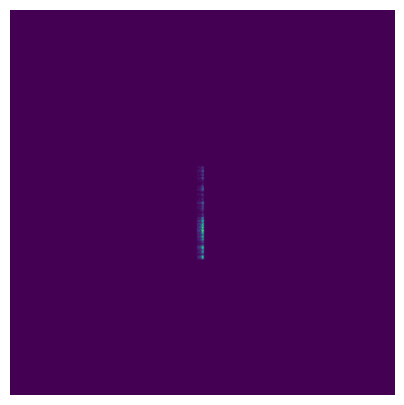

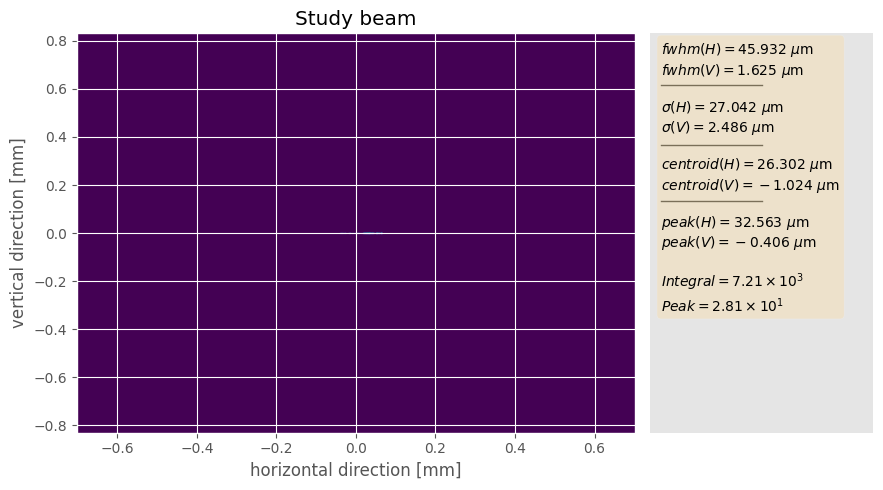

In [73]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    print(vals)
    plt.figure(figsize=[5, 5])
    plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    plt.axis("off")
    plt.show()
    plot_distribution(
        beam=opt_trial.beam_state.photon_beam,
        title="Study beam",
        plot_mode=plot_mode,
        aspect_ratio=aspect_ratio,
        color_map=color_map,
        **sim_params.params,
    )

In [74]:
t.user_attrs['dw'].__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.02704241958156673,
  'h_fwhm': 0.04593164062499988,
  'h_centroid': 0.026301982544595023,
  'h_peak': 0.029821289062500034,
  'v_sigma': 0.0024857559461136467,
  'v_fwhm': 0.0016250000000002096,
  'v_centroid': -0.0010238489044197938,
  'v_peak': -0.0004062499999999969,
  'integral_intensity': 7214.646683732741,
  'peak_intensity': 28.613450103133626,
  'gaussian_fit': {}}}

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_48594/1226614177.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

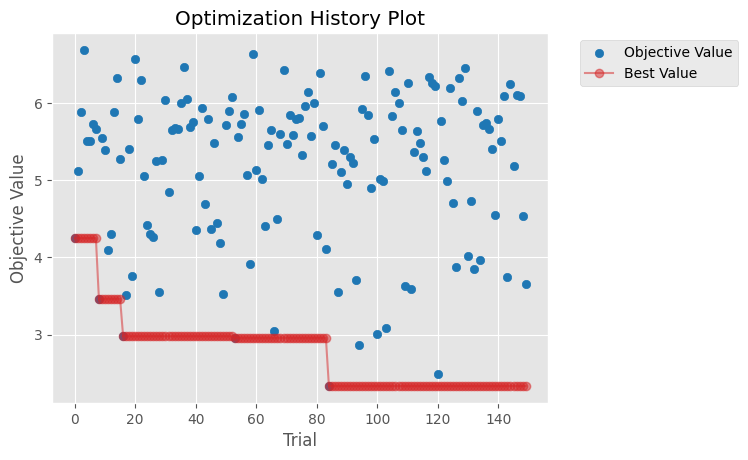

In [75]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study)
                                                        

                                                                            

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_48594/3187813870.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study,


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='peak_distance'>

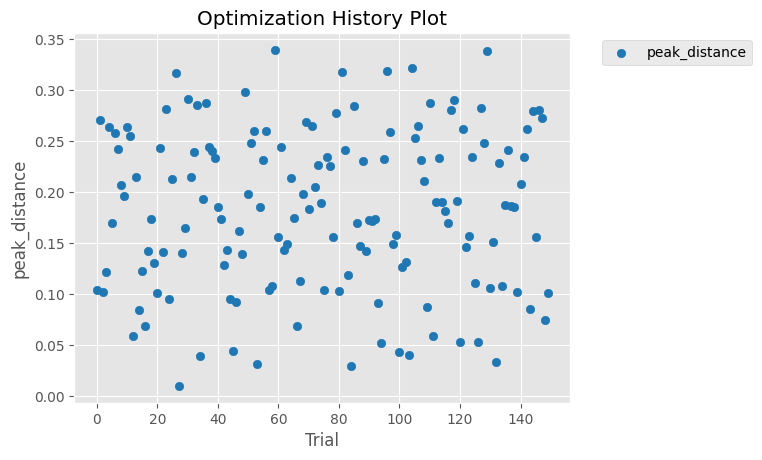

In [43]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study, 
                                                          target=lambda t: (t.user_attrs['dw'].get_parameter('h_peak')**2 + 
                                                                            t.user_attrs['dw'].get_parameter('v_peak')**2)**0.5,
                                                          target_name='peak_distance')

                                                                            

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_48594/632252770.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study,


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='fwhm'>

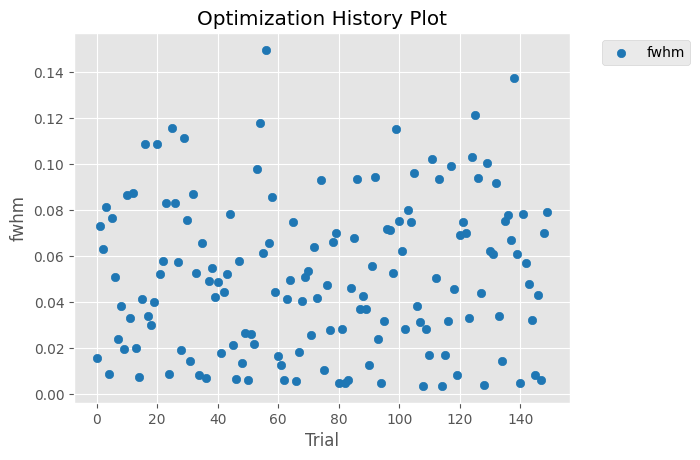

In [44]:
optuna.visualization.matplotlib.plot_optimization_history(opt_trial.study, 
                                                          target=lambda t: (t.user_attrs['dw'].get_parameter('h_fwhm')**2 + 
                                                                            t.user_attrs['dw'].get_parameter('v_fwhm')**2)**0.5,
                                                          target_name='fwhm')

                                                                            